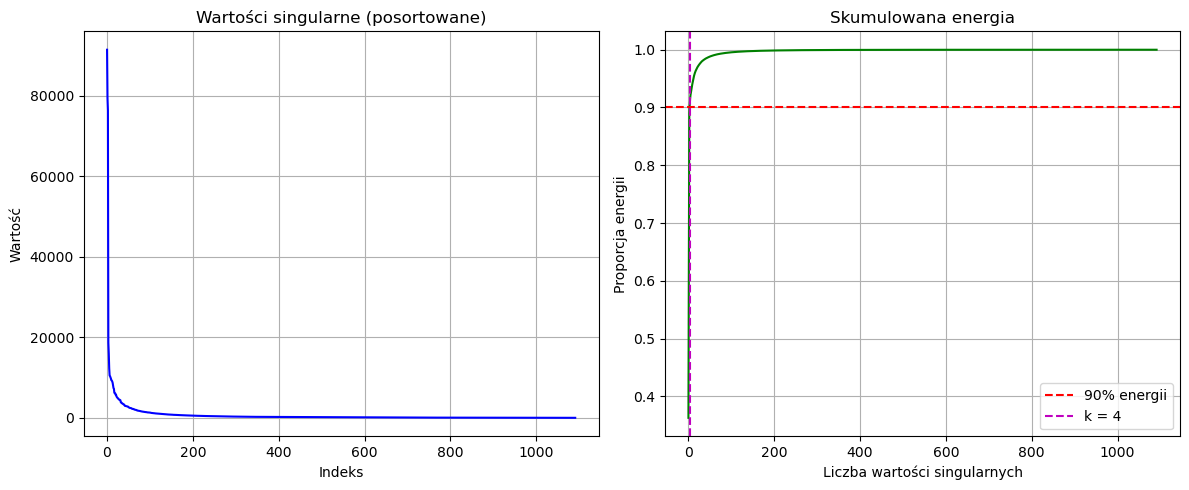

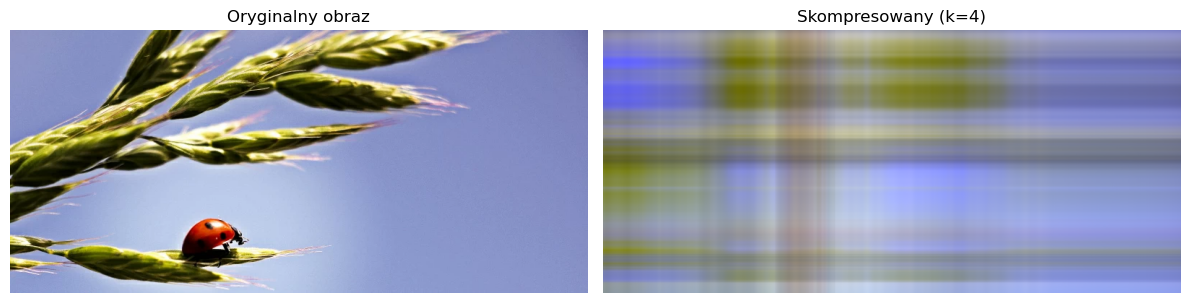

Wymagana liczba wartości singularnych: 4


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Wczytaj obraz
img = Image.open("15.webp")
original_img = np.array(img)

# Przygotuj kanały
if img.mode == 'RGB':
    channels = [original_img[:, :, i] for i in range(3)]
else:
    channels = [original_img]

# Przechowuj informacje o SVD dla każdego kanału
channels_svd = []
s_combined = []

for channel_idx, channel in enumerate(channels):
    U, s, Vt = np.linalg.svd(channel, full_matrices=False)
    channels_svd.append((U, s, Vt))
    s_combined.extend([(val, channel_idx) for val in s])  # (wartość, kanał)

# Sortuj wartości singularne malejąco
s_sorted = sorted(s_combined, key=lambda x: -x[0])

# Oblicz energię
s_values = [val for val, _ in s_sorted]
s_squared = np.array(s_values) ** 2
total_energy = np.sum(s_squared)
cumulative_energy = np.cumsum(s_squared) / total_energy

# Znajdź k
k = np.argmax(cumulative_energy >= 0.9) + 1

# Wykresy analityczne
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(s_values, 'b')
plt.title('Wartości singularne (posortowane)')
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_energy, 'g')
plt.axhline(0.9, color='r', linestyle='--', label='90% energii')
plt.axvline(k-1, color='m', linestyle='--', label=f'k = {k}')
plt.title('Skumulowana energia')
plt.xlabel('Liczba wartości singularnych')
plt.ylabel('Proporcja energii')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Rekonstrukcja obrazu z k wartościami singularnymi
channel_counts = [0] * len(channels)
for i in range(k):
    _, channel_idx = s_sorted[i]
    channel_counts[channel_idx] += 1

reconstructed = []
for i, (U, s, Vt) in enumerate(channels_svd):
    cnt = channel_counts[i]
    Sigma = np.zeros((U.shape[1], Vt.shape[0]))
    Sigma[:cnt, :cnt] = np.diag(s[:cnt])
    reconstructed_channel = U @ Sigma @ Vt
    reconstructed.append(np.clip(reconstructed_channel, 0, 255).astype(np.uint8))

# Złóż obraz wynikowy
if img.mode == 'RGB':
    compressed_img = np.stack(reconstructed, axis=2)
else:
    compressed_img = reconstructed[0]

# Wizualizacja wyników
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Oryginalny obraz")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Skompresowany (k={k})")
plt.imshow(compressed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Wymagana liczba wartości singularnych: {k}")